# Importações dos dados e instalações de bibliotecas

In [ ]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
import os
import re
from datetime import datetime
import gdown

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, Lion
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
tf.random.set_seed(42)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

### Baixando dados

- Aqui teríamos uma API que tem o recebimento dessa base de dados - pode ser como CSV

In [ ]:
# Dados de consumo
# !gdown 1-cZ9YQRJbb3eZTF3PqPz52uDGAXdOGtx
!gdown 1cHO3bohcg-MxWj7tREjLjzxVANsYMJSe # 2024
# !gdown 1MWbkm7-OIUPM1Bq0Oscij-68cXDcCg_R
# !gdown 1iLbj0BvQOXFCs6ORlBSPUshkiH8PBbYo
# !gdown 1fdKVN3eIouzwumukr57m0WNcHxIpj_ej
# !gdown 17p5UBI3WU_O2Zv-5n7tpJUPgq3MamZNw

Downloading...
From (original): https://drive.google.com/uc?id=1cHO3bohcg-MxWj7tREjLjzxVANsYMJSe
From (redirected): https://drive.google.com/uc?id=1cHO3bohcg-MxWj7tREjLjzxVANsYMJSe&confirm=t&uuid=454b2bd7-5c31-43a5-bac7-469b52c709b1
To: /content/CONSUMO_2024.csv
100% 668M/668M [00:06<00:00, 106MB/s]


- A base de fraudes não seria incluida como recebimento na API, mas como algo apartado para ser estruturado toda vez que é necessário um retreino da IA

In [ ]:
# Fraudes
!gdown 1iZBUheWYMZn1FEgvf5I7ga_w1EEwz6mK

Downloading...
From: https://drive.google.com/uc?id=1iZBUheWYMZn1FEgvf5I7ga_w1EEwz6mK
To: /content/FRAUDES_HIST.csv
100% 97.5M/97.5M [00:01<00:00, 69.8MB/s]


### Leitura dos arquivos

- CONSUMO

In [ ]:
# df_2019 = pd.read_csv('/content/CONSUMO_2019.csv', delimiter=';', index_col='Unnamed: 0')
# df_2020 = pd.read_csv('/content/CONSUMO_2020.csv', delimiter=';', index_col='Unnamed: 0')
# df_2021 = pd.read_csv('/content/CONSUMO_2021.csv', delimiter=';', index_col='Unnamed: 0')
# df_2022 = pd.read_csv('/content/CONSUMO_2022.csv', delimiter=';', index_col='Unnamed: 0')
# df_2023 = pd.read_csv('/content/CONSUMO_2023.csv', delimiter=';', index_col='Unnamed: 0')
df_2024 = pd.read_csv('/content/CONSUMO_2024.csv', delimiter=';', index_col='Unnamed: 0')

<ipython-input-5-280cf49a9ff5>:6: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2024 = pd.read_csv('/content/CONSUMO_2024.csv', delimiter=';', index_col='Unnamed: 0')


- FRAUDES

In [ ]:
df_fraude = pd.read_csv('/content/FRAUDES_HIST.csv', delimiter=';', index_col='Unnamed: 0')

### Exploratória - fazer mais a fundo

In [ ]:
# Função para encontrar colunas com um único valor
def colunas_com_valor_unico(df):
    colunas_unicas = [col for col in df.columns if df[col].nunique() == 1]
    return colunas_unicas

# Verificando as colunas com valor único em cada dataframe
colunas_unicas_2024 = colunas_com_valor_unico(df_2024)

# Exibindo os resultados
print("Colunas com valor único em 2024:", colunas_unicas_2024)

Colunas com valor único em 2024: ['EMP_CODIGO', 'ECO_OUTRAS', 'FATURADO_MEDIA']


In [ ]:
# Função para verificar valores faltantes
def verificar_valores_faltantes(df, ano):
    print(f"Valores faltantes no Dataset {ano}:")
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Filtra apenas colunas com valores faltantes
    print(missing_values)
    print("\n")

# Verificando valores faltantes em todos os datasets
verificar_valores_faltantes(df_2024, 2024)

Valores faltantes no Dataset 2024:
COD_GRUPO                   14
COD_SETOR_COMERCIAL         14
NUM_QUADRA                  14
COD_ROTA_LEITURA            14
DAT_LEITURA              21059
COD_LEITURA_INF_1      2703715
COD_LEITURA_INF_2      2799986
COD_LEITURA_INF_3      2805435
FATURADO_MEDIA         2744825
COD_LATITUDE                24
COD_LONGITUDE               24
dtype: int64




# Tratamento de dados

Para o nosso projeto, foram cridos pré-processamentos com o intuito de garantir que os dados estejam em um formato adequado para alimentar o modelo de deep learning, otimizando o processo de aprendizado e aumentando a precisão das previsões. Este processo inclui várias etapas cruciais, que são fundamentais para preparar os dados de forma consistente e padronizada, visando garantir que o modelo possa extrair padrões significativos e fornecer previsões mais precisas e confiáveis:

* Conversão do tipo de dados: a etapa de Conversão do Tipo de Dados será aplicada para garantir que os dados estejam no formato adequado para processamento pelo modelo de deep learning. Essa etapa assegura que os tipos de dados, como números e datas, estejam corretamente formatados, o que é crucial para evitar erros e para que o modelo possa interpretar e aprender a partir dos dados de forma eficaz.

* Transformação para parquet: A etapa de Transformação para Parquet será aplicada para garantir que os dados sejam armazenados em um formato otimizado para eficiência e velocidade. O formato Parquet  facilita o acesso rápido e reduz o espaço em disco, além de melhorar a performance durante o processamento dos dados.

* Remoção de colunas: remoção das colunas referentes as features que não serão utilizadas pelo modelo.

* Normalização: A normalização será aplicada para escalar os dados dentro de um intervalo específico, entre 0 e 1. Isso é essencial para assegurar que todas as características tenham a mesma importância durante o treinamento do modelo, evitando que atributos com valores mais altos dominem o aprendizado e ajudando a acelerar a convergência do algoritmo.

* Tratamento de Texto: Para uniformizar os dados textuais, todo o texto será convertido para maiúsculas e caracteres especiais serão removidos. Essas transformações são necessárias para garantir consistência na forma como as palavras são processadas, eliminando variações que possam confundir o modelo.

* One Hot Encoding: As variáveis categóricas serão convertidas em uma representação numérica utilizando o One Hot Encoding. Essa técnica é crucial para transformar dados categóricos em um formato compatível com o modelo de deep learning, garantindo que as categorias sejam tratadas de maneira uniforme, sem a criação de hierarquias falsas, e permitindo que o modelo interprete cada categoria como uma entidade independente.

* Redimensionamento do Data Frame: Para se adequar a um formato adequado para rede neural foi realizado o redimensionamento do dataframe, fazendo assim com que cada linha vire uma matrícula diferente, e com que os dados referentes a cada mês vire uma coluna diferente. Assim possibilitando que seja feita uma análise referente a cada matrícula

### Conversão dos tipos de dados

In [ ]:
def convert_data_types(datasets):
  for column in datasets.select_dtypes(include=['float64', 'int64']).columns:
      if column not in ["COD_LATITUDE", "COD_LONGITUDE"]:
          datasets[column] = datasets[column].astype('Int64')

  # Convert specific object columns to datetime
  if 'REFERENCIA' in datasets.columns:
      datasets['REFERENCIA'] = pd.to_datetime(datasets['REFERENCIA'], errors='coerce')
  if 'DAT_LEITURA' in datasets.columns:
      datasets['DAT_LEITURA'] = pd.to_datetime(datasets['DAT_LEITURA'], errors='coerce')
  return datasets

### Transformação para parquet- retirada por enquanto

In [ ]:
def transform_load_parquet(df_consumo):
  # Extrair o ano do DataFrame
  # year = df_consumo['REFERENCIA'].dt.year.unique()[0]
  # month = df_consumo['REFERENCIA'].dt.months.unique()[0]
  # file_name = 'CONSUMO_' + str(year) + '.parquet'

  # Salvar como Parquet
  df_consumo.to_parquet(engine='pyarrow', compression='snappy')
  # print(f'Salvo: {file_name}')

- Essa função servirá para juntar o dataset novo com o antigo
- Iremos ignorar o primeiro mês no dataset antigo e adicionar o novo mês, de forma a manter uma faixa de 6 meses de dados

In [ ]:
# def load_parquet_files():
#   dataframes_consumo = {}

#   # Concatenar todos os DataFrames em um único DataFrame
#   df_geral = pd.concat(dataframes_consumo_geral, ignore_index=True)

#   return dataframes_consumo_geral, df_geral

### Remoção de colunas

Codigo para remoção de colunas referentes à features que não serão utilizadas para o treinamento do modelo.

- Analisar depois, pois pode ser interessante retirar todas as colunas que possuem ECO
- essas três colunas podem ser interessantes de retornar para o modelo:
 - STA_TROCA
 - EXCECAO
 - STA_ACEITA_LEITURA
 - VOLUME_ESTIMADO_ACUM
 - VOLUME_ESTIMADO

In [ ]:
def drop_columns(df, column_name):
  df = df.drop(column_name, axis=1)
  return df

### Normalização

Normalização dos dados para garantir que todas as variáveis tivessem uma escala comparável, evitando que alguma variável dominasse o modelo devido a valores mais altos.

In [ ]:
def normalize_column(df, column_name):
    # Cria uma instância do RobustScaler
    scaler = RobustScaler()

    # Ajusta o scaler à coluna e transforma os dados
    df_normalized = df.copy()
    df_normalized[column_name] = scaler.fit_transform(df[[column_name]])

    return df_normalized[column_name]

### Padronização das colunas

Padronização das colunas de texto de forma a evitar possiveis problemas causados por textos mal formatados.

In [ ]:
def padronizar_texto(df, column_name):

  # Cria uma cópia da coluna para evitar modificações no DataFrame original
  new_column = df[column_name].copy()

  # Converte todos os textos para maiúsculas
  new_column = new_column.str.upper()

  # Remove caracteres especiais
  new_column = new_column.apply(lambda x: re.sub(r'[^a-zA-Z0-9]', '', str(x)))

  return new_column

In [ ]:
def agrupar_valores(df, column_name):
  df[column_name] = df[column_name].apply(lambda x: 'NORMAL' if x == 'NORMAL' else 'ANORMALIDADE')
  return df

Vale mencionar que a função realiza tanto a padronização dos textos para maiusculos tanto a remoção de qualquer carctere especial.

### One hot encoding

Codificação One-Hot para garantir que as variáveis categóricas sejam representadas de forma adequada no modelo, evitando que o algoritmo interprete erroneamente as categorias.

In [ ]:
def one_hot_encoding(df, column_name):
  df_encoded = pd.get_dummies(df, columns=[column_name], prefix=[column_name])
  return df_encoded

### Criação de categoria de consumo - depois vou arrumar isso

Tramento para criação de categorias de consumo, que podem sem utilizadas para ánalise

In [ ]:
def categorizar_consumo(df, column_name):


  # Criação novas colunas para as categorias de consumo
  df['Consumo_Alto'] = 0
  df['Consumo_Medio'] = 0
  df['Consumo_Baixo'] = 0

  # Categorizando o consumo
  df.loc[df[column_name] > 0.7, 'Consumo_Alto'] = 1
  df.loc[(df[column_name] >= 0.2) & (df[column_name] <= 0.7), 'Consumo_Medio'] = 1
  df.loc[df[column_name] < 0.2, 'Consumo_Baixo'] = 1

  return df

### Redimensionamento do dataframe:

Codigo para redimensionar a tabela, visando tranformar cada linha do dataframe em uma matricula, e cada mês em uma coluna propria no dataframe:


In [ ]:
def redimensionar_dataframe(df, coluna_data, coluna_matricula, colunas_features):
    # Converte a coluna de data para datetime
    df[coluna_data] = pd.to_datetime(df[coluna_data])

    # Determina a data mais recente (M) no DataFrame
    data_maxima = df[coluna_data].max()

    # Calcula a datas do intervalo
    data_limite = data_maxima - pd.DateOffset(months=5) # vamos mudar a quantidade de meses que iremos rodar # Mude aqui para alterar o range de datas

    # Filtra o DataFrame para manter apenas as datas definidas
    df = df[(df[coluna_data] >= data_limite) & (df[coluna_data] <= data_maxima)]

    # Cria um dicionário para armazenar os dados redimensionados
    dados_redimensionados = {}

    # Identifica as colunas que não estão nas colunas_features
    colunas_estaticas = [col for col in df.columns if col not in colunas_features and col not in [coluna_data, coluna_matricula]]

    # Itera sobre as matrículas únicas
    for matricula in df[coluna_matricula].unique():
        # Filtra o DataFrame para a matrícula atual
        df_matricula = df[df[coluna_matricula] == matricula]
        # Cria um dicionário para a matrícula atual
        dados_matricula = {coluna_matricula: matricula}
        # Adiciona as colunas estáticas
        for coluna in colunas_estaticas:
            dados_matricula[coluna] = df_matricula[coluna].iloc[0]
        for coluna in colunas_features:
            # Cria uma coluna para cada mês
            for i, data in enumerate(pd.date_range(data_limite, data_maxima, freq='M')):
                valor = df_matricula.loc[df_matricula[coluna_data] == data, coluna].iloc[0] if data in df_matricula[coluna_data].values else 0
                dados_matricula[f"{coluna}_M-{i}"] = valor
        # Adiciona os dados da matrícula ao dicionário principal
        dados_redimensionados[matricula] = dados_matricula

    # Cria um novo DataFrame a partir do dicionário redimensionado
    df_redimensionado = pd.DataFrame.from_dict(dados_redimensionados, orient='index')
    # Substitui todos os NaN por 0 no DataFrame final
    df_redimensionado.fillna(0, inplace=True)
    return df_redimensionado

# Construindo Pipe de tratamento

Para garantir que os dados sejam processados corretamente, foi desenvolvida uma pipeline de pré-processamento robusta e flexível, capaz de se adaptar a diferentes data frames. Essa pipeline foi projetada para executar de forma automática todos os tratamentos necessários, conforme descrito no tópico de pré-processamento de dados. Com isso, assegura-se que cada conjunto de dados seja tratado de maneira adequada e consistente, independentemente das suas particularidades ou formatos, assim sendo adaptavel as nescecidades de cada dataframe e possibilitando a adição de novas bases ao projeto.

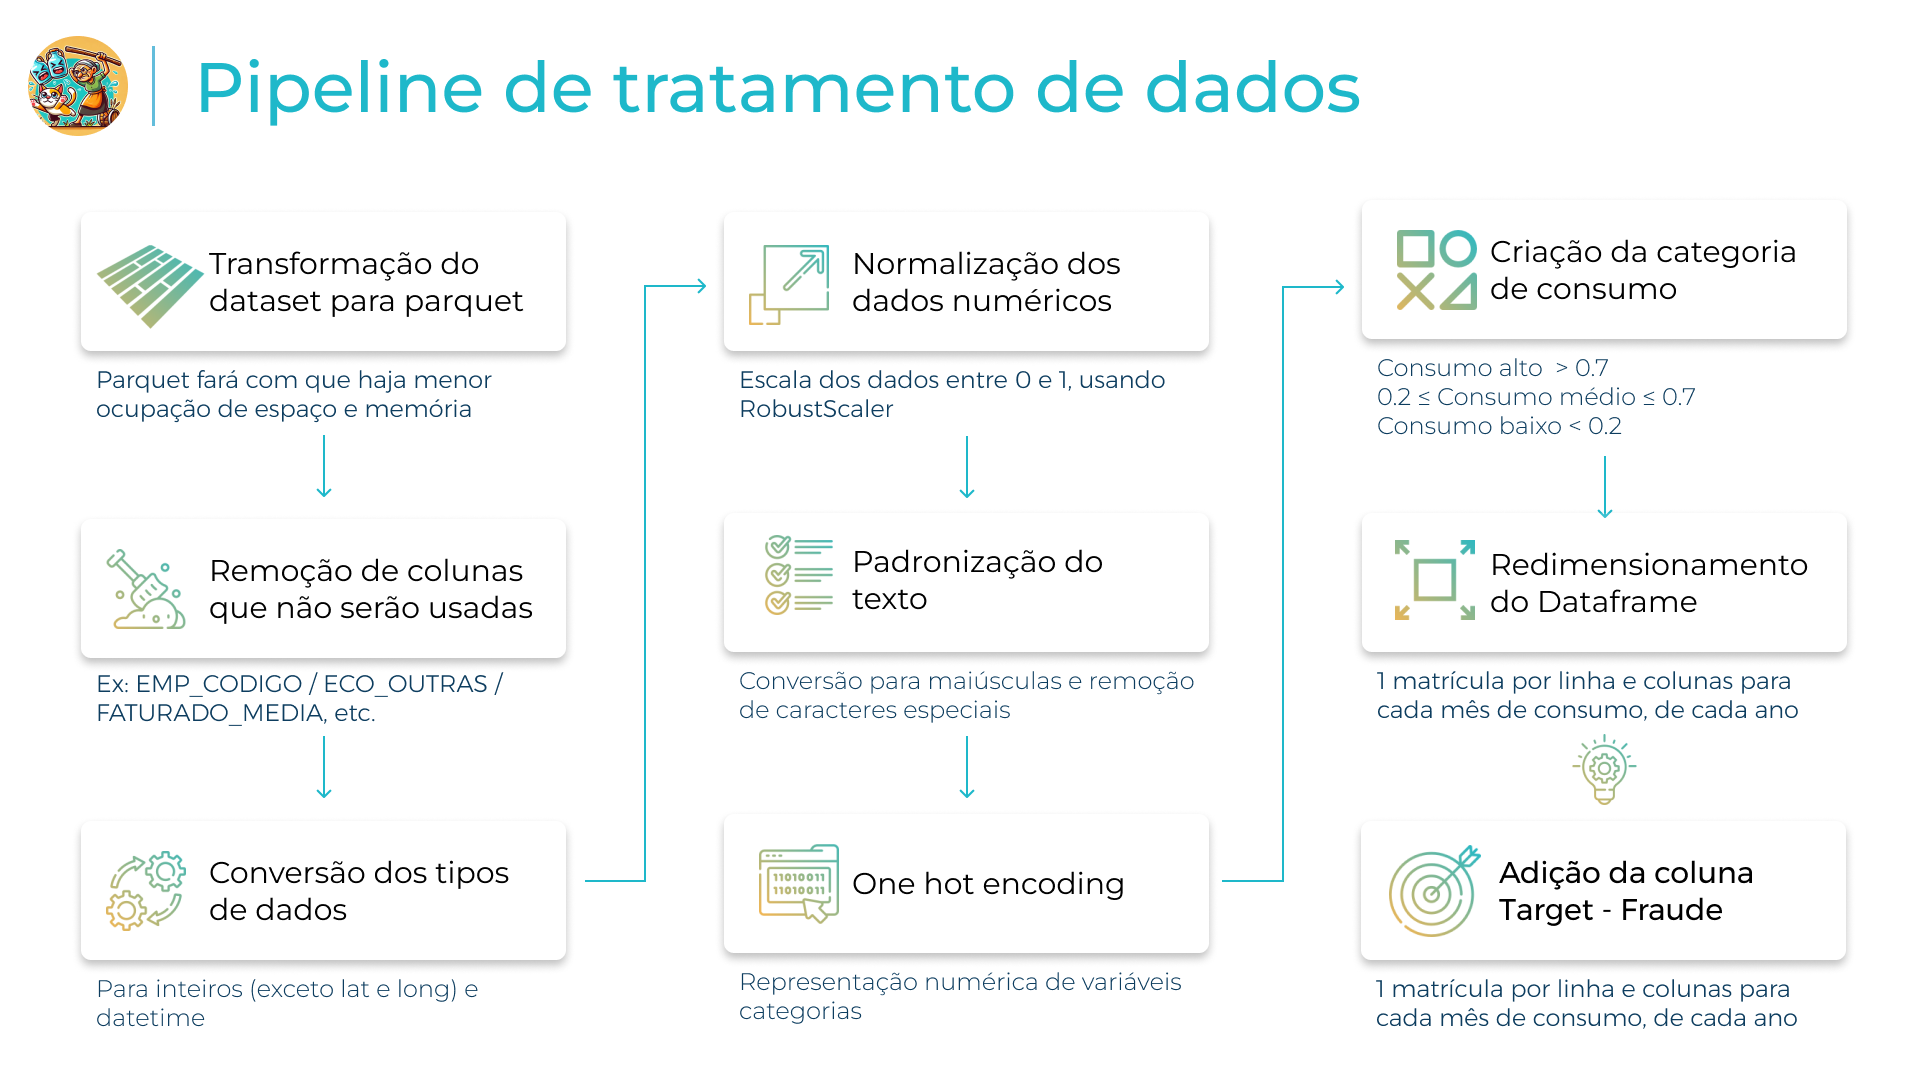

In [ ]:
def pipeline_tratamento(df_CONSUMO, colunas_remover, colunas_normalizar, colunas_padronizar, colunas_agrupamento, colunas_onehot, coluna_consumo, coluna_data, coluna_matricula, colunas_features):
  # A função de parquet foi retirada por enquanto
  # dataset_parquet = transform_load_parquet(dataset)

  for coluna_drop in colunas_remover:
      df_CONSUMO = drop_columns(df_CONSUMO, coluna_drop)

  df_CONSUMO = convert_data_types(df_CONSUMO)

  # Normalização
  for coluna_norm in colunas_normalizar:
      df_CONSUMO[coluna_norm] = normalize_column(df_CONSUMO, coluna_norm)

  # Padronização de texto
  for coluna_padrao in colunas_padronizar:
      df_CONSUMO[coluna_padrao] = padronizar_texto(df_CONSUMO, coluna_padrao)

  # Agrupamento de texto
  for coluna_agrupar in colunas_agrupamento:
      df_CONSUMO[coluna_padrao] = padronizar_texto(df_CONSUMO, coluna_padrao)

  # One-hot encoding
  for coluna_one in colunas_onehot:
      df_CONSUMO = one_hot_encoding(df_CONSUMO, coluna_one)

  # Criação de categorias de consumo
  df_CONSUMO = categorizar_consumo(df_CONSUMO, coluna_consumo)

  # aplicar o PCA aqui

  # Redimensionamento do DataFrame
  df_CONSUMO = redimensionar_dataframe(df_CONSUMO, coluna_data, coluna_matricula, colunas_features)

  return df_CONSUMO

# Aplicando pipe de tratamento

Abaixo é possivel visualizar a aplicação da pipe descrita no topico anterior:

In [ ]:
df_CONSUMO = df_2024.copy()
colunas_remover =  ['EMP_CODIGO', 'COD_GRUPO', 'COD_SETOR_COMERCIAL', 'ECO_OUTRAS', 'FATURADO_MEDIA', 'COD_LEITURA_INF_1', 'COD_LEITURA_INF_2', 'COD_LEITURA_INF_3', 'COD_LATITUDE', 'COD_LONGITUDE', 'LTR_ATUAL', 'LTR_COLETADA', 'HORA_LEITURA', 'COD_LEITURA_INT', 'STA_ACEITA_LEITURA', 'STA_TROCA', 'EXCECAO', 'VOLUME_ESTIMADO', 'VOLUME_ESTIMADO_ACUM'] # colunas que não quero no dataset
colunas_normalizar = ['CONS_MEDIDO'] # colunas que quero fazer o min e max, tirando os outliers.
colunas_padronizar = ['DSC_SIMULTANEA', 'DSC_OCORRENCIA', 'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA'] # padronização do texto = regex
colunas_agrupamento = ['DSC_OCORRENCIA']
colunas_onehot = ['DSC_SIMULTANEA', 'DSC_OCORRENCIA', 'TIPO_LIGACAO', 'CATEGORIA', 'SUB_CATEGORIA'] # para a função de one hot, é melhor usar para texto

coluna_consumo = 'CONS_MEDIDO' # coluna de referencia de consumo

coluna_data = 'REFERENCIA' # coluna referencia de datas
coluna_matricula = 'MATRICULA' # coluna de referencia de id
colunas_features = ['CONS_MEDIDO'] #,'LTR_ATUAL','LTR_COLETADA'] # aqui para features é onde eu uso as colunas com números, que estão associadas a cada mês

df_pipe = pipeline_tratamento(df_CONSUMO, colunas_remover, colunas_normalizar, colunas_padronizar, colunas_agrupamento, colunas_onehot, coluna_consumo, coluna_data,coluna_matricula,colunas_features)
df_pipe.head()

<ipython-input-18-7d401df3b4bd>:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_redimensionado.fillna(0, inplace=True)


,MATRICULA,NUM_QUADRA,COD_ROTA_LEITURA,SEQ_RESPONSAVEL,ECO_RESIDENCIAL,ECO_COMERCIAL,ECO_INDUSTRIAL,ECO_PUBLICA,DAT_LEITURA,DIAS_LEITURA,...,SUB_CATEGORIA_RESSOCIAL,SUB_CATEGORIA_RSOCIALHOMEX,Consumo_Alto,Consumo_Medio,Consumo_Baixo,CONS_MEDIDO_M-0,CONS_MEDIDO_M-1,CONS_MEDIDO_M-2,CONS_MEDIDO_M-3,CONS_MEDIDO_M-4
17188010,17188010,16,11,581756,0,1,0,0,2024-05-06 00:00:00,31,...,False,False,1,0,0,0,0,0,0,0
17424465,17424465,60,38,188809,1,0,0,0,2024-06-04 00:00:00,31,...,False,False,0,0,1,0,0,0,0,0
17857770,17857770,314,9,454315,1,0,0,0,2024-07-17 00:00:00,31,...,False,False,0,0,1,0,0,0,0,0
17702922,17702922,112,25,311133,0,2,0,0,2024-03-11 00:00:00,31,...,False,False,0,0,1,0,0,0,0,0
17504522,17504522,254,40,207433,1,0,0,0,0,0,...,False,False,0,0,1,0,0,0,0,0


In [ ]:
df_pipe.shape

(389509, 105)

In [ ]:
df_pipe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 389509 entries, 17188010 to 17851930
Columns: 104 entries, MATRICULA to CONS_MEDIDO_M-4
dtypes: bool(86), int64(17), object(1)
memory usage: 88.4+ MB


# Adição da coluna target - FRAUDE

Além do tratamento, tambem e nescessario adicionar a nossa coluna target do modelo, no nosso caso e se uma matricula já fraudou ou não. E para isso e nescessario juntar a tabela de consumo e de fraudes:

In [ ]:
df_fraude = df_fraude.copy()
df_fraude = convert_data_types(df_fraude)
# Cria um conjunto com as matrículas fraudulentas
matriculas_fraudulentas = set(df_fraude['MATRICULA'])

# Cria a coluna 'fraude' no df_pipe_teste e inicializa com 0
df_pipe['fraude'] = 0

# Define o valor 1 para as matrículas presentes no conjunto de matrículas fraudulentas
df_pipe.loc[df_pipe['MATRICULA'].isin(matriculas_fraudulentas), 'fraude'] = 1

In [ ]:
df_pipe['fraude'].value_counts()

,count
fraude,
0,265864
1,123645


In [ ]:
# Salvando para parquet
df_pipe.to_parquet('df_pipe.parquet')

# Aplicando o UnderSample

- Aqui estamos aplicando o Undersample, uma forma de equilibrar a disparidade de valores não fraudes e fraudes, de forma a passar uma visão mais uniforme para o modelo